# Scaffold hopping by holistic molecular representation in drug design

#### Francesca Grisoni,* Gisbert Schneider

ETH Zurich, Department of Chemistry and Applied Biosciences, RETHINK, Vladimir-Prelog-Weg 4, 8093, Zurich, Switzerland. <div>
*Corresponding author: francesca.grisoni@pharma.ethz.ch 


## Table of Contents
1. [Preliminary steps](#preliminary)
2. [Molecule import and pre-treatment](#import)
3. [WHALES descriptors](#whales) <div>
    a. [*WHALES calculation*](#calculation) <div>
    b. [*Descriptor scaling*](#scaling)
4. [Virtual screening](#vs)<div>
    a. [*Similarity calculation*](#similarity)<div>
    b. [*Identification of top hits*](#tophits)<div>
5. [Scaffold analysis](#scaffold)<div>
    a. [*Template scaffold*](#templatescaffold)<div>
    b. [*Library scaffold diversity*](#libraryscaffold)<div>
    c. [*Scaffold diversity of the top hits*](#tophitsscaffold)<div>
6. [How to cite](#cite) 

# Import of necessary packages <a name="preliminary"></a>

Here you will find all of the necessary packages that will be used in this Jupyter Notebook. No worries, they should all be installed already in your virtual environment!

In [2]:
# chemistry toolkits
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # for molecule depiction
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
# WHALES-related code
import ChemTools as tools # for molecule pretreatment
import do_whales # importing WHALES descriptors
from ChemTools import prepare_mol_from_sdf # to pretreat the virtual screening library
# for data analysis and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
import numpy
# to delete before uploading
%load_ext autoreload
%autoreload
%reload_ext ChemTools
%reload_ext do_whales

# Molecule import and pre-treatment <a name="import"></a>

## Template molecule

Import and visualization of galantamine, starting from SMILES

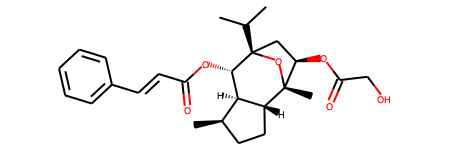

In [3]:
# import template from SMILES
template = Chem.MolFromSmiles('C[C@@H]1CC[C@@H]2[C@@H]1[C@@H]([C@@]3(C[C@H]([C@]2(O3)C)OC(=O)CO)C(C)C)OC(=O)/C=C/c4ccccc4') # imports from SMILES
# add 2D coordinates for visualization
err = AllChem.Compute2DCoords(template)
template

Prepare the molecule, by checking for errors and optimizing the 3D conformation

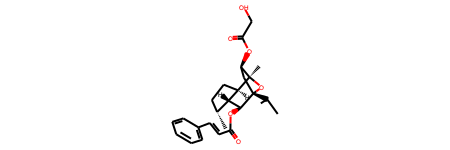

In [4]:
mol, err = tools.prepare_mol(template)
mol

Inspect the partial charges that will be used for WHALES calculation

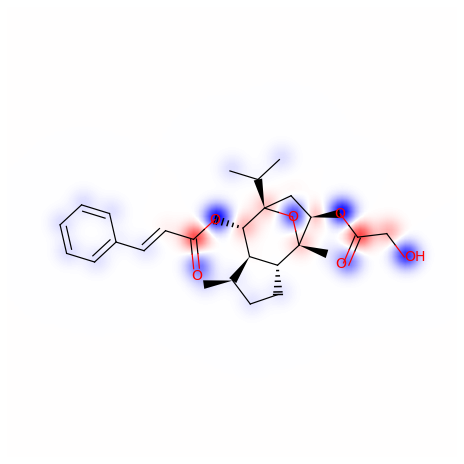

In [5]:
tools.do_map(template,lab_atom=True)

In [6]:
writer = Chem.rdmolfiles.SDWriter('out.sdf')
writer.write(mol)

## Compound library

Import and prepare library

In [7]:
# set the path to the sdf file for input and output
input_filename = '../data/library.sdf'
vs_library_2D = Chem.SDMolSupplier(input_filename) # conserved for 2D representations
vs_library = prepare_mol_from_sdf(input_filename) # computes 3D geometry from a specified sdf file

Molecule: 50
Molecule: 100
Molecule: 150
Molecule: 200
Molecule: 250
Molecule: 300
Molecule: 350
Molecule: 400
Molecule: 450
Molecule: 500
Molecule: 550
Molecule: 600
Molecule: 650
Molecule: 700
Molecule: 750
Molecule: 800
Molecule: 850
Molecule: 900
Molecule: 950
Molecule: 1000


Visually inspect the database after geometry optimization

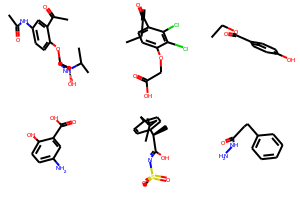

In [8]:
#Visualize the first 6 molecules of the database after geometry optimization
number_mol = 6 # number of molecules to inspect
Draw.MolsToGridImage(vs_library[:number_mol],molsPerRow=3,subImgSize=(100,100),legends=[x.GetProp("_Name") for x in vs_library[:number_mol]])

# WHALES descriptors <a name="whales"></a>

## Descriptors calculation <a name="calculation"></a>

Compute WHALES descriptors for the template molecule

In [9]:
# compute descriptors as an array
whales_template, lab = do_whales.whales_from_mol(template)
# convert the arrays into a pandas dataframe
df_whales_template = pd.DataFrame(whales_template.reshape(-1, len(whales_template)),index=['template'],columns=lab)
df_whales_template

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,-2.202,-1.59,-1.413,-1.17,-0.953,-0.723,-0.479,0.07,0.392,0.481,...,-0.088,-0.054,-0.038,-0.029,-0.022,-0.017,0.018,0.059,0.147,0.226


Compute WHALES for the virtual screening library

In [11]:
whales_library = []
for mol in vs_library: # runs over the library and updates WHALES
    whales_temp, lab = do_whales.whales_from_mol(mol)
    whales_library.append(whales_temp)
# convert the arrays into a pandas dataframe
df_whales_library = pd.DataFrame(whales_library,columns=lab)
df_whales_library.head() # library preview

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
0,-3.872,-1.559,-1.263,-0.988,-0.498,-0.420,0.372,0.531,0.871,1.185,...,-0.171,-0.146,-0.094,-0.062,-0.020,0.034,0.061,0.090,0.158,0.182
1,-3.310,-2.604,-2.182,-1.485,-1.145,-0.870,-0.757,0.455,0.547,0.741,...,-0.153,-0.133,-0.107,-0.075,-0.051,-0.012,0.120,0.185,0.311,0.725
2,-21.571,-1.253,-1.016,-0.962,-0.879,-0.790,-0.712,-0.031,0.372,0.484,...,-0.120,-0.099,-0.091,-0.082,-0.057,-0.026,0.031,0.099,0.179,0.431
3,-1.804,-1.409,-1.120,-1.075,-1.061,-0.991,-0.900,0.463,0.513,0.567,...,-0.351,-0.287,-0.204,-0.163,-0.092,-0.080,0.045,0.458,0.471,0.621
4,-2.831,-2.615,-1.714,-1.426,-1.309,-1.157,-1.015,-0.722,-0.205,0.707,...,-0.200,-0.156,-0.133,-0.123,-0.108,-0.075,-0.034,0.040,0.258,0.642


## Descriptors scaling <a name="scaling"></a>

### Data visualization
Visualizing the raw descriptor values for the virtual screening library using a boxplot

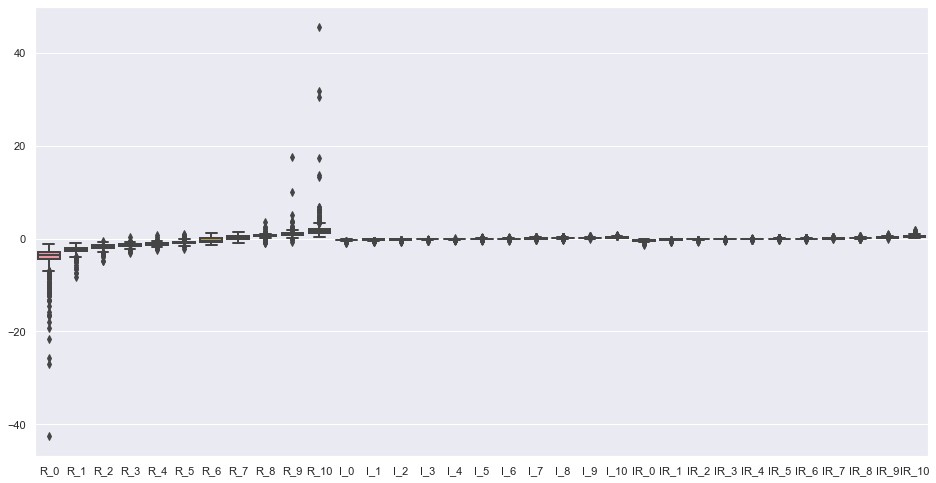

In [12]:
sns.set(rc={'figure.figsize':(16,8.27)}) # sets the size of the boxplot
sns.boxplot(data=df_whales_library,linewidth=2)

### Autoscaling

Virtual library scaling

In [13]:
aver = df_whales_library.mean()
sdv = df_whales_library.std()
df_whales_library_scaled = (df_whales_library - aver)/sdv
df_whales_library_scaled.to_csv('WHALES_after.csv')

Template scaling

In [14]:
df_whales_template_scaled = (df_whales_template - aver)/sdv
df_whales_template_scaled

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,0.704562,1.080383,0.843069,0.728998,0.604692,0.288351,-0.186305,-0.24263,-0.538598,-0.650578,...,1.371447,1.379196,1.344271,1.19762,0.710167,-0.148719,-0.578559,-1.109765,-1.107172,-1.287242


### Data visualization
Visualizing the descriptor values for the virtual screening library after autoscaling


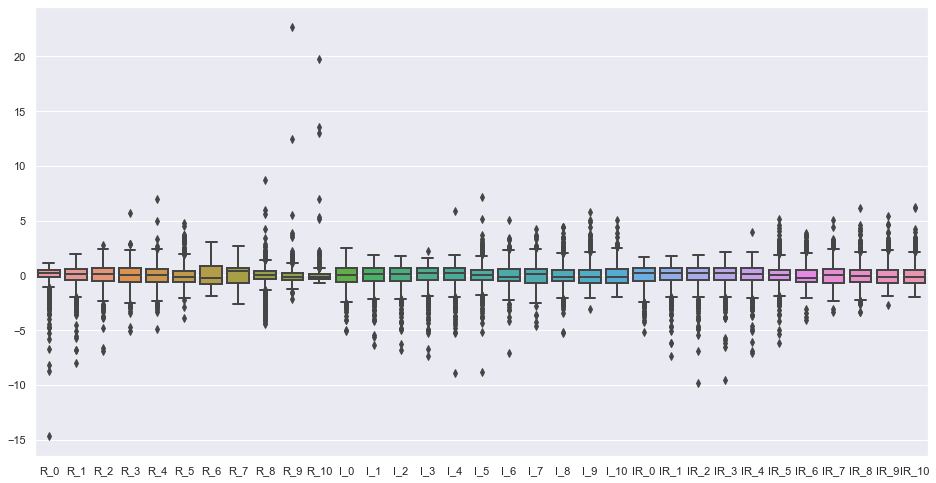

In [15]:
sns.set(rc={'figure.figsize':(16,8.27)})
sns.boxplot(data=df_whales_library_scaled,linewidth=2)

# Virtual screening <a name="vs"></a>

## Similarity calculation <a name="similarity"></a>

In [16]:
# compute Euclidean distance
D = euclidean_distances(df_whales_template_scaled,df_whales_library_scaled)

## Identification of top hits <a name="tophits"></a>
Selection of the 10 closest compounds based on the computed distance on WHALES

In [17]:
# sorting based on distance
sort_index = numpy.argsort(D) # index for sorting according to D
D_neig = D[:,sort_index] # sorted distance

In [18]:
# selection of the 10 closest compounds
k = 10 # number of compounds to choose
neighbor_ID = sort_index[:,0:k]
neighbor_ID

array([[710, 940, 869, 569, 119, 136,  84, 160,  87, 449]])

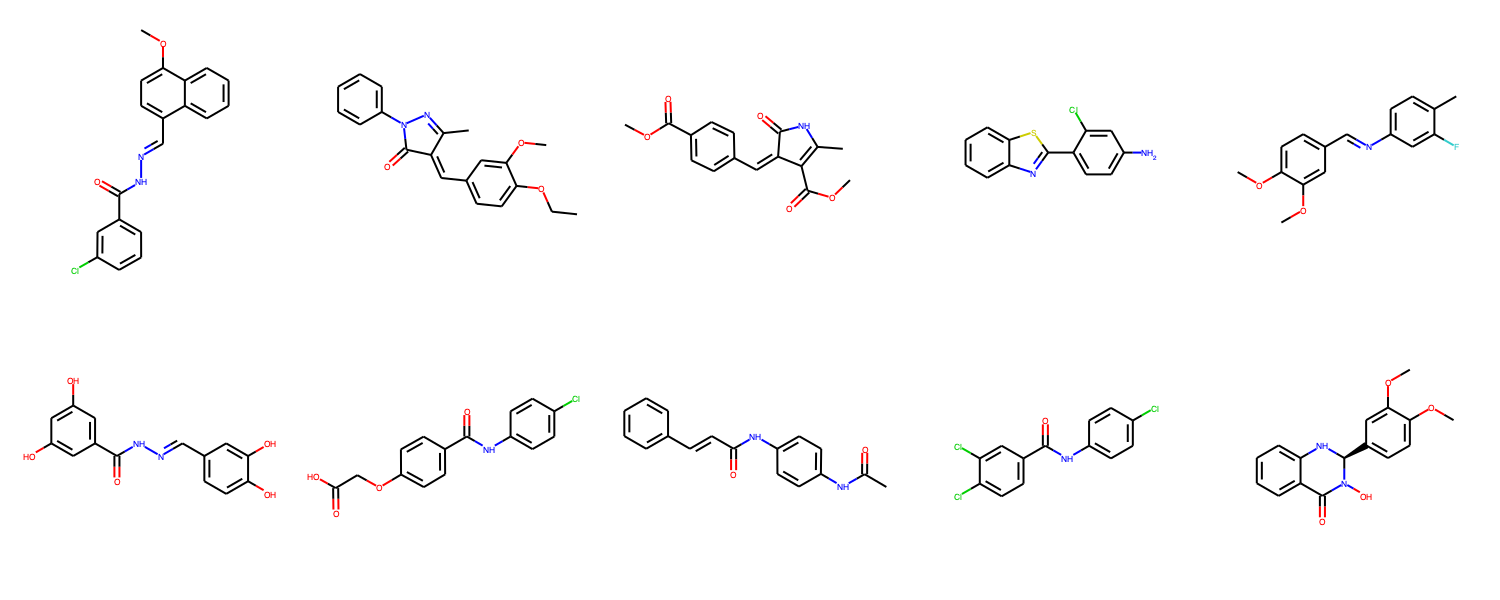

In [19]:
# display of the 10 closest compounds
hits = []
smiles_hits = []
for j in numpy.nditer(neighbor_ID):
    hits.append(vs_library_2D[int(j)])
    smiles_hits.append(Chem.MolToSmiles(mol))

#Visualize the first 10 molecules of the database after geometry optimization
number_mol = 10 # number of molecules to inspect
Draw.MolsToGridImage(hits[:number_mol+1],molsPerRow=5,subImgSize=(300,300),legends=[x.GetProp("_Name") for x in hits[:number_mol+1]])

# Scaffold analysis <a name="scaffold"></a>

## Template scaffold <a name="templatescaffold"></a>

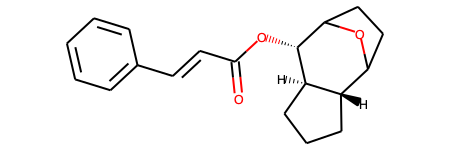

In [20]:
core = MurckoScaffold.GetScaffoldForMol(template)
core

## Scaffold diversity of the virtual screening library

Compute the Bemis-Murcko scaffolds for the virtual screening library

In [21]:
scaffold_vs = [] # generates an empty supplier to contain the computed scaffold
for mol in vs_library_2D:
    scaffold_vs.append(MurckoScaffold.GetScaffoldForMol(mol))

Preview of the scaffolds (4 for display)

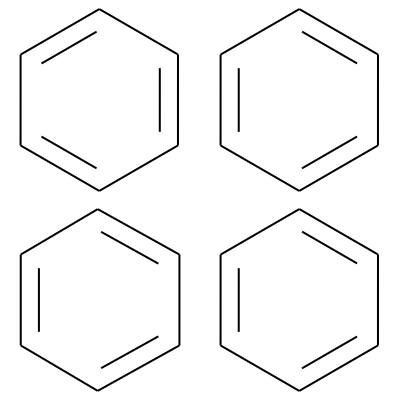

In [22]:
# 4 scaffolds are displayed
k = 4
Draw.MolsToGridImage(scaffold_vs[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_vs[:k]])

Most frequently recurring scaffolds in the virtual screening library

In [23]:
freq_scaffolds_library = tools.frequent_scaffolds(vs_library_2D) # contains the list of the (unique) scaffolds, sorted by number

Display the four most occurring scaffolds

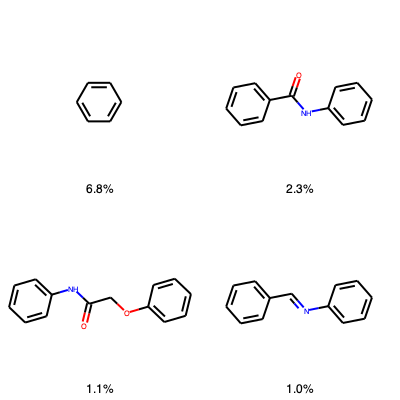

In [24]:
k = 4
Draw.MolsToGridImage(freq_scaffolds_library[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_library[:k]])

Computes the relative scaffold diversity of the library

In [30]:
SD_rel = len(freq_scaffolds_library)/len(vs_library)*100
print(SD_rel)

54.2


## Top hits scaffolds

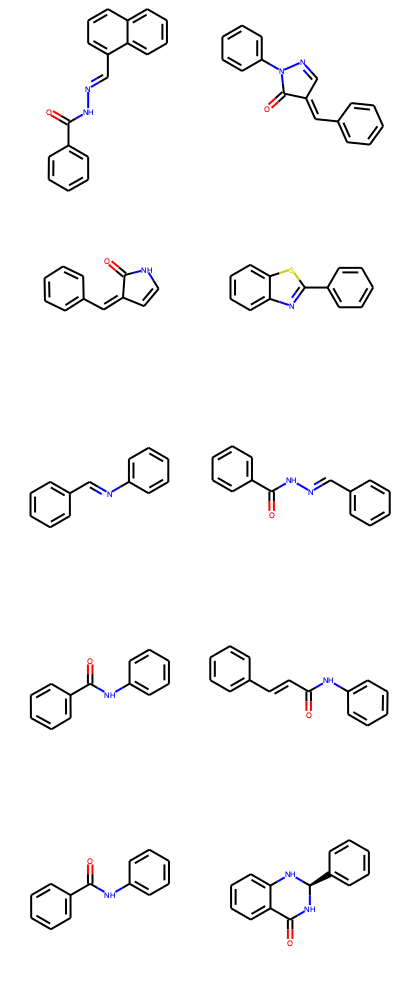

In [25]:
scaffold_hits = []
for mol in hits:
    scaffold_hits.append(MurckoScaffold.GetScaffoldForMol(mol))
 
Draw.MolsToGridImage(scaffold_hits[:10],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_hits[:10]])

Computes the frequent scaffolds and the scaffold diversity

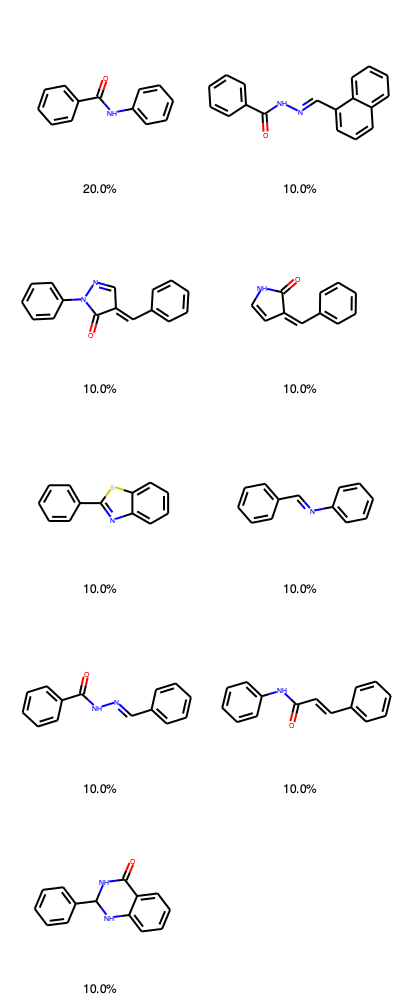

In [38]:
freq_scaffolds_hits = tools.frequent_scaffolds(hits) # contains the list of the (unique) scaffolds, sorted by number
k = len(freq_scaffolds_hits) # display all scaffolds
Draw.MolsToGridImage(freq_scaffolds_hits[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_hits[:k]])

In [39]:
SD_rel = len(freq_scaffolds_hits)/len(hits)*100
print(SD_rel)

90.0
